## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

**Заказчику важны:**
* качество предсказания;
* скорость предсказания;
* время обучения.

*Инструкция по выполнению проекта*

* Загрузите и подготовьте данные.
* Обучите разные модели с различными гиперпараметрами.
* Проанализируйте скорость работы и качество моделей.

*Примечания:*

* Для оценки качества моделей применяйте метрику RMSE.
* Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
* Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:
del features_train

**Описание данных**

*Признаки*

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

In [229]:
!pip install catboost

In [230]:
#common
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import re
import random
import warnings
warnings.simplefilter('ignore')
import calendar

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

#ml
from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils import shuffle, resample

#regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb

In [231]:
cars = pd.read_csv('autos.csv')
cars.drop(['Unnamed: 0'], axis=1, inplace=True)

In [232]:
def cars_info(df):
  print(df.info())
  display(df.head())
  display(df.describe())
  print("Уникальные значения:")
  print(df.nunique())
  print('\nПропущенные значения:')
  print(df.isna().sum())
  print('Дубликаты', df.duplicated().sum())

In [233]:
cars_info(cars)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Уникальные значения:
DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
NotRepaired               2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Пропущенные значения:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
Дубликаты 4


Перед нами задача регрессии.
Датасет содержит: 354369 наблюдений, 15 признаков и 1 целевой признак.

Первично обнаруженные проблемы:

* Пропущенные значения - требуется обработка.
* Вполне вероятно, что дата создания и скачивания объявления, дата последнего визита пользователя, месяц регистрации и почтовый индекс не помогут нам в процессе предсказания цен.
* Большая часть признаков - категориальные. Из количественных - пройденный километраж (150 тысяч на машине 1993 года - охотно верится=), мощность двигателя. Так же, наверное, сюда можно отнести год регистрации.

1. Нет никакой информации о фотографиях.  отбросить данный столбец.
2. В нашем датасете достаточно дешевые автомобили - средняя стоимость = 2700 EUR.
3. Кто-то зарегистрировал автомобиль в 1000м году (сразу после Крещения Руси, там, вероятно, правила постановки на учет обновили), а кто-то подаст документы о регистрации через 8 тысяч лет.
4. Странный максимальный пробег в 150000 километров - встерчается у подавляющего большинства автомобилей. возможно, это особенность сайта - максимальное значение, которое можно выставить = 150000?
5. Сбита кодировка месяцов регистрации. Если максимальный (последний) месяц - декабрь=12, то месяца 0 быть не должно (или наоборот)

In [234]:
# самая часто встречающаяся машина
temp = (cars.groupby(['Brand', 'Model', 'VehicleType'])['Power'].count().sort_values(ascending=False))
temp.head()

Brand       Model   VehicleType
volkswagen  golf    sedan          14744
opel        corsa   small          10499
volkswagen  polo    small          10267
bmw         3er     sedan           8087
volkswagen  passat  wagon           7134
Name: Power, dtype: int64

гольф седан - самый частый автомобиль в анкетах продаж.

In [235]:
# процентные соотношения пропущенных значений
total = cars.isnull().sum().sort_values(ascending = False)
percent = round(cars.isnull().sum().sort_values(ascending = False)/len(cars)*100,2)

pd.concat([total, percent], axis=1, keys=['Total','Percent']).style.background_gradient(cmap='Reds')

,Total,Percent
NotRepaired,71154,20.080000
VehicleType,37490,10.580000
FuelType,32895,9.280000
Gearbox,19833,5.600000
Model,19705,5.560000
LastSeen,0,0.000000
PostalCode,0,0.000000
NumberOfPictures,0,0.000000
DateCreated,0,0.000000
Brand,0,0.000000


* Была ли машина в ремонте? 20% респондентов не смогли ответить на данный вопрос!
Предлагаю заполнить эти пропуски значением 'No', предположу, что данные машины не подвергались ремонту и владельцы просто оставили эту строку пустой в анкете (но лучше сказать об этом тимлиду или посоветоваться с коллегами)
* Тип автомобиля попробуем заполнить по марке и модели. Модель - по марке.
* Тип коробки - по году выпуска.
* Тип топлива - возможно, по модели.

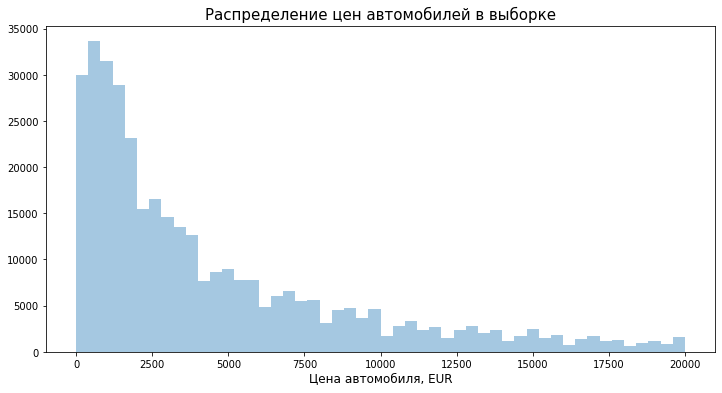

In [236]:
plt.figure(figsize=(12,6))
sns.distplot(cars['Price'], kde=False)

plt.xlabel('Цена автомобиля, EUR', size=12)
plt.title('Распределение цен автомобилей в выборке', size=15);

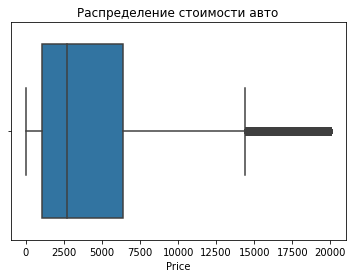

In [237]:
sns.boxplot(cars['Price'])
plt.title('Распределение стоимости авто');

In [238]:
# Удаляю выбросы по цене. Убаляю все что меньше первого квантиля
cars=cars.loc[(cars['Price']>1000) &(cars['Price']<20000)]

In [239]:
# Удаляю выбросы по году регистрации все что < 1980 года
cars=cars.loc[(cars['RegistrationYear']>1980)]

Text(0.5, 0, 'Мощность двигателя, л.с.')

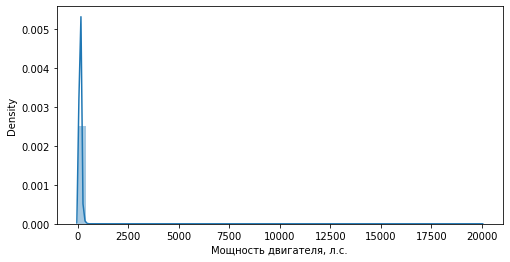

In [240]:
plt.figure(figsize=(8,4))
sns.distplot(cars['Power'])
plt.xlabel('Мощность двигателя, л.с.')

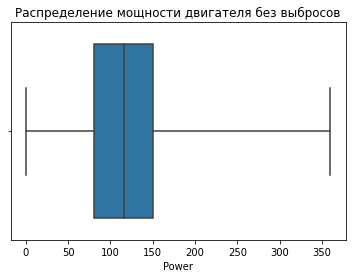

In [241]:
sns.boxplot(cars['Power'], showfliers=False, whis=3)
plt.title('Распределение мощности двигателя без выбросов');

In [242]:
# Удаляю выбросы по мощности
cars=cars.loc[(cars['Power']>70)&(cars['Power']<350)]

## Заполнение пропусков
**Был ли автомобиль в ремонте**

Как указывалось выше, предлагаю все пропущенные значения здесь заполнить строкой 'No'.
Хотя можно предположить, что автомобили без указанного ремонта - очень старые автомобили, тогда можно, в принципе, задуматься о значениях 'yes' в данном столбце.

Проверим гипотезу о том, что "не бита и не крашена" - это все старинные автомобили.

In [243]:
print('\nПропущенные значения:')
print(cars.isna().sum())


Пропущенные значения:
DateCrawled              0
Price                    0
VehicleType          11891
RegistrationYear         0
Gearbox               2898
Power                    0
Model                 6993
Kilometer                0
RegistrationMonth        0
FuelType             10616
Brand                    0
NotRepaired          26626
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [244]:
not_rep = cars.loc[cars['NotRepaired'].isna()]['RegistrationYear'].value_counts()
not_rep_perc = not_rep.head(10).sum() / cars.loc[cars['NotRepaired'].isna(), 'Price'].count()

print(not_rep.head(10))
print()
print('"Новые" автомобили без указания ремонта, составляют {:.2%} от общего количества'.format((not_rep_perc)))

2005    2046
2017    1898
2004    1811
2003    1758
2002    1666
2000    1645
1999    1590
2001    1586
2006    1498
2007    1268
Name: RegistrationYear, dtype: int64

"Новые" автомобили без указания ремонта, составляют 62.97% от общего количества



Гипотеза не подтверждена - большинство автомобилей относительно новые.
Заменяем пропуски значениями 'no'

In [245]:
cars['NotRepaired'] = cars['NotRepaired'].fillna(value='no')

**Коробка передач**

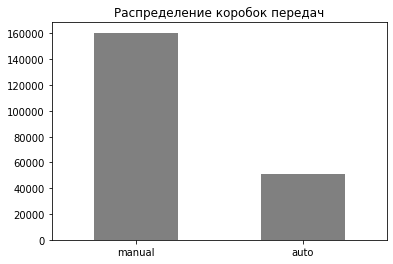

In [246]:
plt.figure()
cars['Gearbox'].value_counts().plot(kind='bar', color='grey')
plt.xticks(rotation=0)
plt.title('Распределение коробок передач');

есть предположение, что тип коропки несильно влияет на цену, и, возможно, его можно будет вообще не учитывать при построении моделей.

In [247]:
cars['GearboxUnsorted'] = cars['Gearbox'].fillna(value='unsorted')
cars['Gearbox'] = cars['Gearbox'].fillna('manual')

**Модель автомобиля**

In [248]:
temp = pd.DataFrame(cars.groupby(['Brand'])['Model'].count()).reset_index()
temp.sort_values(by='Model', ascending=False).tail()

,Brand,Model
8,daihatsu,146
17,lancia,140
7,daewoo,130
16,lada,110
33,sonstige_autos,0


Первое, что мы видим - странная марка sontige_autos - вообще не имеет моделей.
Яндекс подсказал нам - что это словосочетание переводится с немецкого, как "другой автомобиль". Вероятно, марки такого автомобиля не было в базе сайта.

In [249]:
len(cars.query('Brand == "sonstige_autos"'))

1069

In [250]:
len(cars.loc[cars['Model']=="other"])


13789

Предлагаю модели "других автомобилей" заполнить значениями "оther", так как мы никак больше не восстановим данные пропуски.

In [251]:
cars.loc[cars['Brand']=='sonstige_autos', 'Model'] = cars.loc[cars['Brand']=='sonstige_autos', 'Model'].fillna('other')

В данном случае - залью пропуски модели самыми частыми представителями по брендам.

In [252]:
mod_dict = cars.groupby(['Brand'])['Model'].apply(lambda x: x.mode()[0])
cars['Model'] = cars['Model'].fillna(cars['Brand'].map(mod_dict))

In [253]:
cars['Model'].isna().sum()

0

**Тип кузова**

Вполне вероятно, что тип кузова автомобиля не влияет на цену. Однако, все равно заполним пропущенные значения.

Создаем словарь с наиболее часто встречающими значениями типа кузова, сгруппированных по моделям автомобилей. Заполняем этими значениями пропуски.

In [254]:
vt_dict = dict(cars.groupby(['Model'])['VehicleType'].apply(lambda x: x.mode()[0]))
cars['VehicleType'] = cars['VehicleType'].fillna(cars['Model'].map(vt_dict))

**Тип топлива**
Посмотрим, на все доступные типы топлива (вдруг, там есть уголь).

In [255]:
cars['FuelType'].value_counts()

petrol      118536
gasoline     81137
lpg           3936
cng            398
hybrid         192
other           35
electric        18
Name: FuelType, dtype: int64


есть электрокары, гибриды, сжиженные углеводороды и газ.

В данном случае забьем пропуски по марке автомобиля.

In [256]:
fuel_dict = cars.groupby(['Model'])['FuelType'].apply(lambda x: x.mode()[0])
cars['FuelType'] = cars['FuelType'].fillna(cars['Model'].map(fuel_dict))

In [257]:
cars.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
GearboxUnsorted      0
dtype: int64

**Вывод** 

На данном этапе был произведен анализ данных и предобработка пропущенных значений.
* В первую очередь было выдвинуто предположение об исключении фич с датами регистрации анкеты, последнего визита пользователя, количества фотографий и даты снятия анкеты, поскольку они имеют корреляцию с ценой автомобиля (напомню, что фотографий вообше не было, все значения = 0).
* В ходе анализа установлено, что бОльшая часть автомобилей лежит в ценовой категории 1,5 тыс Евро, встречаются образцы и за 20 тысяч. Несколько тысяч автомобилей не попали под имеющиеся категории марок и были оставлены в сете, как 'sonstige_autos".
* Так же в ходе данного шага были обработаны все пропуенные значения, в основном, на основании группировки сета по модели, году регистрации и марке автомобиля.

Предобработка и анализ данных завершен, переходим к обучению и тестированию моделей.




# 2. Обучение моделей


* Изучим две модели Градиентного бустинга : CatBoost, LightGBM и Линейную регрессию
* Проверим все три модели на дефолтных параметрах без какого-либо тюнинга модели и посмотрим какие результаты они нам покажут.
сохраним все результаты для дальнейшего анализа

In [258]:
RND_ST = 1234

In [259]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,GearboxUnsorted
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,manual
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,auto
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,manual
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,manual
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13,manual


In [260]:
unnec_col = ['Price', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen', 'GearboxUnsorted']

In [261]:
# Опредлим признаки и целевой признак 
X = cars.drop(unnec_col, axis=1)
y = cars['Price']

#разделим датасет на обучающую и тестовую выборку размеров 80 на 20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=RND_ST)

#Из обучающей выборки вытянем валидационную.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=RND_ST)

#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X_train.shape[0], X_train.shape[1]))
print('Размер валидационной выборки: {} объектов, {} признаков'.format(X_valid.shape[0], X_valid.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))




Размер обучающей выборки: 128920 объектов, 9 признаков
Размер валидационной выборки: 42974 объектов, 9 признаков
Размер тестовой выборки: 42974 объектов, 9 признаков


In [262]:
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,bus,2014,manual,125,c_max,30000,petrol,ford,no


In [263]:
#Определяю индексы для столбцов не типа int. Те нахожу категориальные столбцы
cat_feat=np.where(X.dtypes!= np.int64)[0]
cat_feat

array([0, 2, 4, 6, 7, 8])

**CatBoost**

In [264]:
X_train_val_c, X_test_c, y_train_val_c, y_test_c = train_test_split(
    X, y, test_size=0.2, random_state=RND_ST)

 
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(
    X_train_val_c, y_train_val_c, test_size=0.25, random_state=RND_ST)


print(X_train_c.shape[0], X_valid_c.shape[0], X_test_c.shape[0])

128920 42974 42974


In [265]:
train_pool = Pool(X_train_c, 
                  y_train_c, 
                  cat_features=cat_feat)

valid_pool = Pool(X_valid_c, 
                  y_valid_c, 
                  cat_features=cat_feat)

test_pool = Pool(X_test_c, 
                 cat_features=cat_feat)

In [266]:
# Задаем модель с параметрами
cbr = CatBoostRegressor(depth=7, 
                        learning_rate=1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        random_state=RND_ST, 
                        iterations=500)

In [267]:
%%time
cbr.fit(train_pool)

0:	learn: 2690.1667178	total: 161ms	remaining: 1m 20s
50:	learn: 1734.8189930	total: 5.49s	remaining: 48.4s
100:	learn: 1665.4299411	total: 10.7s	remaining: 42.2s
150:	learn: 1617.8286816	total: 15.9s	remaining: 36.8s
200:	learn: 1585.6109503	total: 21.1s	remaining: 31.3s
250:	learn: 1555.5287549	total: 26.2s	remaining: 26s
300:	learn: 1528.0351087	total: 31.5s	remaining: 20.8s
350:	learn: 1508.9829257	total: 36.5s	remaining: 15.5s
400:	learn: 1492.2211634	total: 41.2s	remaining: 10.2s
450:	learn: 1475.9678288	total: 46.2s	remaining: 5.02s
499:	learn: 1459.3296271	total: 51.2s	remaining: 0us
CPU times: user 1min 35s, sys: 4.82 s, total: 1min 40s
Wall time: 51.8 s


In [268]:
predict=cbr.predict(X_train_c)
rmse=mean_squared_error(predict, y_train_c)
print('RMSE на обучающей выборке', np.sqrt(rmse))
print()

RMSE на обучающей выборке 1518.7928347873585



In [269]:
predict=cbr.predict(X_valid_c)
rmse=mean_squared_error(predict,y_valid_c)
print('RMSE на валидационной выборке', np.sqrt(rmse))
print()

RMSE на валидационной выборке 1746.897164342371



**LightGBM**

In [270]:
features_light = X.copy()

In [271]:
# Нахожу категориальные признаки
cat_features_index=np.where(features_light.dtypes==np.object)
cat_features_index

(array([0, 2, 4, 6, 7, 8]),)

In [272]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [273]:
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,bus,2014,manual,125,c_max,30000,petrol,ford,no


In [274]:
cat_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
features_light[cat_feat] = enc.fit_transform(features_light[cat_feat]).astype('int')

In [275]:
features_light.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,2,2011,1,190,28,125000,2,1,1
2,6,2004,0,163,115,125000,2,14,0
3,5,2001,1,75,114,150000,6,37,0
6,1,2004,1,109,8,150000,6,25,0
8,0,2014,1,125,59,30000,6,10,0


In [276]:
X_train_val_l, X_test_l, y_train_val_l, y_test_l = train_test_split(
    features_light, y, test_size=0.2, random_state=RND_ST)

 
X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(
    X_train_val_l, y_train_val_l, test_size=0.25, random_state=RND_ST)


print(X_train_l.shape[0], X_valid_l.shape[0], X_test_l.shape[0])

128920 42974 42974


In [277]:
train_data = lgb.Dataset(X_train_l, y_train_l)
valid_data = lgb.Dataset(X_valid_l, y_valid_l) 
test_data = lgb.Dataset(X_test_l)

In [278]:
params = {
    'boosting_type': 'gbdt',
    'tree_learner':'feature',
    'objective': 'regression',
    'max_depth':12,
    'num_leaves': 300,
    'min_data_in_leaf':300,
    'max_bin':100,
    'learning_rate': 0.35,
    'num_iteration':150,
    'metric':'rmse',
    'verbose': 1
}
n_estimators = 2000


In [279]:
%%time
lgb = lgb.train(params, train_data, n_estimators)

CPU times: user 3.87 s, sys: 104 ms, total: 3.98 s
Wall time: 2.19 s


In [280]:
predict=lgb.predict(X_train_l)
rmse=mean_squared_error(predict, y_train_l)
print('RMSE на обучающей выборке', np.sqrt(rmse))
print()

RMSE на обучающей выборке 1582.7318944276176



In [281]:
predict=lgb.predict(X_valid_l)
rmse=mean_squared_error(predict,y_valid_l)
print('RMSE на валидационной выборке', np.sqrt(rmse))
print()

RMSE на валидационной выборке 1713.494927496638



**XGboost**

In [282]:
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(
    features_light, y, test_size=0.2, random_state=RND_ST)
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RND_ST)


In [283]:
dtrain = xgb.DMatrix(X_train_, y_train_)
dval = xgb.DMatrix(X_valid_, y_valid_)
dtest = xgb.DMatrix(X_test_)

In [284]:
%%time
param = {'max_depth':6, 
         'eta':0.5, 
         'min_child_weight':4,
         'sampling_method':'gradient_based', 
         'verbosity':1,  
         'seed':RND_ST}

num_round = 45

bst = xgb.train(param, dtrain, num_round)

CPU times: user 7.97 s, sys: 18.9 ms, total: 7.99 s
Wall time: 4.08 s


In [285]:
predict=bst.predict(xgb.DMatrix(X_train_))
rmse=mean_squared_error(predict, y_train_)
print('RMSE на обучающей выборке', np.sqrt(rmse))
print()

RMSE на обучающей выборке 1682.5314685683172



In [286]:
predict=bst.predict(xgb.DMatrix(X_valid_))
rmse=mean_squared_error(predict,y_valid_)
print('RMSE на валидационной выборке', np.sqrt(rmse))
print()

RMSE на валидационной выборке 1793.7504386764404



**LinearRegression**

In [287]:
lr = LinearRegression()

In [288]:
X_train_val_lr, X_test_lr, y_train_val_lr, y_test_lr = train_test_split(
    features_light, y, test_size=0.2, random_state=RND_ST)
X_train_lr, X_valid_lr, y_train_lr, y_valid_lr = train_test_split(
    X_train_val_lr, y_train_val_lr, test_size=0.25, random_state=RND_ST)

In [289]:
%%time
lr.fit(X_train_lr, y_train_lr)

CPU times: user 28 ms, sys: 10.1 ms, total: 38.2 ms
Wall time: 35.3 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [290]:
predict=lr.predict(X_train_lr)
rmse=mean_squared_error(predict, y_train_lr)
print('RMSE на обучающей выборке', np.sqrt(rmse))
print()

RMSE на обучающей выборке 3270.053661067683



In [291]:
predict=lr.predict(X_valid_lr)
rmse=mean_squared_error(predict,y_valid_lr)
print('RMSE на валидационной выборке', np.sqrt(rmse))
print()

RMSE на валидационной выборке 3314.946883443201



## Вывод
На данном шаге было проведено тестирование четыре модели:

* CatBoost
* LightGBM
* xgboost
* LinearRegression

Быстрее всех учится и предсказывает xgboost, занимая при этом второе место по качеству предсказаний. Наилучшую метрику rmse на валидационной выборке показал LightGBM.

В целом, сейчас уже можно выбросить из конкурса LinearRegression, однако, произведем замеры rmse всех моделей на тестовой выборке.

# 3 Анализ моделей

**На данном этапе определим метрику rmse всех моделей на оставшейся тестовой выборке.**

In [292]:
%%time
predict=cbr.predict(X_test_c)
rmse=mean_squared_error(predict, y_test_c)
print('RMSE CATBOOST на обучающей выборке', np.sqrt(rmse))
print()

RMSE CATBOOST на обучающей выборке 1749.6345998570405

CPU times: user 402 ms, sys: 64.4 ms, total: 466 ms
Wall time: 256 ms


In [293]:
%%time
predict=lgb.predict(X_test_l)
rmse=mean_squared_error(predict, y_test_l)
print('RMSE LIGHTGBM на обучающей выборке', np.sqrt(rmse))
print()

RMSE LIGHTGBM на обучающей выборке 1700.8397500286212

CPU times: user 1.14 s, sys: 4.72 ms, total: 1.14 s
Wall time: 598 ms


In [294]:
%%time
predict=bst.predict(xgb.DMatrix(X_test_))
rmse=mean_squared_error(predict, y_test_)
print('RMSE XGBOOST на обучающей выборке', np.sqrt(rmse))
print()

RMSE XGBOOST на обучающей выборке 1780.5374082786464

CPU times: user 184 ms, sys: 847 µs, total: 185 ms
Wall time: 112 ms


In [302]:
%%time
predict=lr.predict(X_test_lr)
rmse=mean_squared_error(predict, y_test_lr)
print('RMSE LINEAR на обучающей выборке', np.sqrt(rmse))
print()

RMSE LINEAR на обучающей выборке 3286.149464493565

CPU times: user 2.98 ms, sys: 1.95 ms, total: 4.93 ms
Wall time: 3.39 ms


In [296]:
res = {
    'model_name':pd.Series(['CatBoost', 'lightGBM', 'xgboost', 'LinearRegression']),
    'training_time':pd.Series([51.8,2.14,4.22,0.35]),
    'prediction_test_time':pd.Series([0,0,0,0]), 
    'rmse_test':pd.Series([0,0,0,0])}

In [297]:
results = pd.DataFrame(res)
results

,model_name,training_time,prediction_test_time,rmse_test
0,CatBoost,51.80,0,0
1,lightGBM,2.14,0,0
2,xgboost,4.22,0,0
3,LinearRegression,0.30,0,0


Соберем все данные в таблицу результатов.

In [307]:
results.loc[0,'prediction_test_time'] = 466
results.loc[0,'rmse_test'] = 1749.6

results.loc[1,'prediction_test_time'] = 1140
results.loc[1,'rmse_test'] = 1700.8

results.loc[2,'prediction_test_time'] = 185
results.loc[2,'rmse_test'] = 1780.3

results.loc[3,'prediction_test_time'] = 4930
results.loc[3,'rmse_test'] = 3286.1

In [308]:
results

,model_name,training_time,prediction_test_time,rmse_test
0,CatBoost,51.80,466,1749.6
1,lightGBM,2.14,1140,1700.8
2,xgboost,4.22,185,1780.3
3,LinearRegression,0.30,4930,3286.1


In [309]:
temp = results.copy().sort_values(by=['rmse_test'])
temp

,model_name,training_time,prediction_test_time,rmse_test
1,lightGBM,2.14,1140,1700.8
0,CatBoost,51.80,466,1749.6
2,xgboost,4.22,185,1780.3
3,LinearRegression,0.30,4930,3286.1


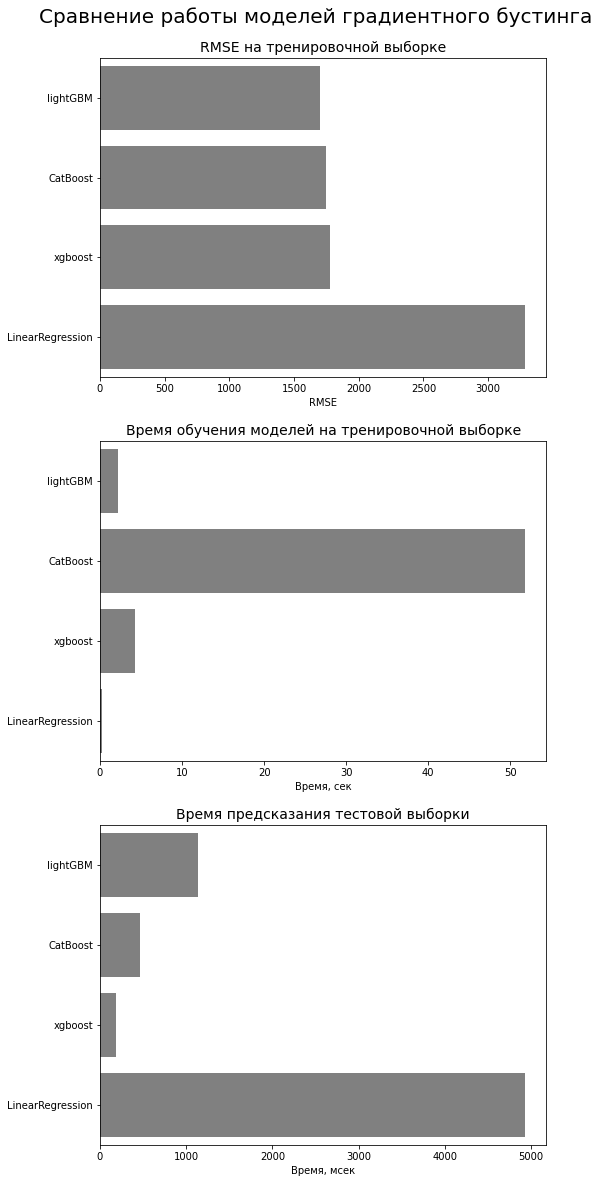

In [310]:
fig, axes = plt.subplots(3,1 , figsize=(8,20))

sns.barplot(y=temp['model_name'], x=temp['rmse_test'], color='gray', ax=axes[0], orient='h')
sns.barplot(y=temp['model_name'], x=temp['training_time'], color='gray', ax=axes[1], orient='h')
sns.barplot(y=temp['model_name'], x=temp['prediction_test_time'], color='gray', ax=axes[2], orient='h')

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[0].set_xlabel('RMSE')
axes[1].set_xlabel('Время, сек')
axes[2].set_xlabel('Время, мсек')

axes[0].set_title('RMSE на тренировочной выборке', size=14)
axes[1].set_title('Время обучения моделей на тренировочной выборке', size=14)
axes[2].set_title('Время предсказания тестовой выборки', size=14)

plt.suptitle('Сравнение работы моделей градиентного бустинга', size=20, y=(0.915));

Все модели показали "средние" результаты.
Можно лучше настроить гиперпараметры, а так же заняться более глубоким features engeneering.

Лидером по качеству предсказаний становится LightGBM, самая быстрая модель обучения и предсказания - xgboost.

**Итог - наилучшее решение - модель LightGBM - средняя скорость работы и лучшее качество**

## Вывод

На данном этапе были проанализированны 4 модели. Приемлемой моделью признана LightGBM, с наилучшими показателями RMSE и достаточно хорошим временем работы, относительно других моделей.


# Общий вывод

Целью настоящего исследования ставилось тестирование и подбор наилучшей модели для имеющихся данных.

В исследовании приняли участие 4 модели : 'LightGBM', 'CatBoost', 'LinearRegression', 'XgBoost'
Основной метрикой тестрирования стал корень среднеквадратичной ошибки.

На первом этапе исследования был произведен анализ данных и заполнены пропущенные значения.

На втором этапе кейса было протестировано, в общей сложности, 4 модели (3 модели градиентного бустинга и 1 линейная модель)


Наилучшей и рекомендованной к использованию моделью признана LightGBM - со значением RMSE на тестовой выборке = 1700.8 и временем обучения = 1,5 минуты.

Несмотря на достаточно хороший показатель, считаю, что можно достичь лучшей метрики, но уже на локальной машине с лучшим подбором гиперпараметров.

В целом - исследование можно считать завершенным. Основные задачи - изучение и тестирование моделей градиентного бустинга - успешно выполнены.

